### Tricks to improve accuracy
0. random seed
1. First run to compute the train dataset's mean and std, apply it to dataset pre-processing
2. Add BN layer
3. Initialize FC's weights to normal(0.01, 0.1), bias to 0, BN's weight to 1, bias to 0
4. Adam
5. Set lr decay scheduler to STEP and add epochs

PS: MacOS, python3.6, torch 1.0

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.nn as nn

In [21]:
# hyperparameters
batch_size = 64
lr = 3e-2
print_freq = 200
epochs = 5

In [22]:
# build train dataset and test dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.13066], std=[0.09493])]),
                               download=True)
test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.13066], std=[0.09493])]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [16]:
# build model
# (fc -> bn -> relu) -> (fc -> bn -> relu) -> fc
class mlp(nn.Module):
    def __init__(self, init=False):
        super(mlp, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
#         self.relu = nn.LeakyReLU()
#         self.relu = nn.Sigmoid()
        self.models = [self.fc1, self.bn1, self.fc2, self.bn2, self.fc3]
        
        if not init:
            self._init()
            
    def _init(self):
        for m in self.models:
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.01, 0.1)
#                 nn.init.kaiming_normal_(m.weight, nonlinearity='leaky_relu')
                m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

In [17]:
# random seed
torch.manual_seed(0)
np.random.seed(0)

# build model, adam optimizer, lr scheduler and loss function
model = mlp()
optimizer = torch.optim.Adam(model.parameters(), lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2)
criteria = nn.CrossEntropyLoss()

### 1. train phase

iter 0: loss 2.608524
iter 200: loss 0.335888
iter 400: loss 0.074990
iter 600: loss 0.296608
iter 800: loss 0.111003
iter 1000: loss 0.038041
iter 1200: loss 0.004573
iter 1400: loss 0.064720
iter 1600: loss 0.081320
iter 1800: loss 0.004659
iter 2000: loss 0.022592
iter 2200: loss 0.030645
iter 2400: loss 0.117268
iter 2600: loss 0.071426
iter 2800: loss 0.015026
iter 3000: loss 0.012379
iter 3200: loss 0.010663
iter 3400: loss 0.017270
iter 3600: loss 0.206690
iter 3800: loss 0.028931
iter 4000: loss 0.029855
iter 4200: loss 0.009837
iter 4400: loss 0.033873
iter 4600: loss 0.009252
iter 4800: loss 0.002814


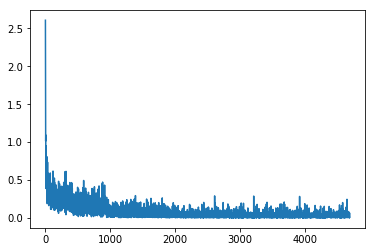

In [18]:
model.train()
losses = []
# samples = 0
# mean = 0
# first run to compute the train dataset's mean and var
samples = 60000
mean = 0.13066
var = 0.09493
for epoch in range(epochs):
    # lr decay every epoch
    scheduler.step()

    for i, (data, target) in enumerate(train_loader):
        output = model(data.reshape(data.shape[0], -1))
    
        loss = criteria(output, target)
        if i % print_freq == 0:
            print("iter {}: loss {:.6f}".format(i+epoch*1000, loss.data))
        # BP
        losses.append(float(loss.data))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
#     samples += data.shape[0]
#     mean += float(data.sum())
#     var += float(((data - mean) ** 2).sum())
# mean /= (samples * 28 * 28)
# var /= (samples * 28 * 28)
plt.plot(np.arange(len(losses)), losses)
plt.show()

### 2.Test phase

In [20]:
# set model to eval mode and test
model.eval()
samples = 0
acc = 0
for i, (data, target) in enumerate(test_loader):
    output = model(data.reshape(data.shape[0], -1))
    _, pred = torch.max(output, dim=1)
    acc += float((pred == target).sum())
    samples += output.shape[0]

print(acc / samples)

0.9841
